In [1]:
! pip install nibabel
! pip install nilearn
! pip install -q nilearn

In [2]:
import nibabel as nib
import pandas as pd
import os
import numpy as np

In [3]:
run='1'

behav_data_path = f'/Users/graceliu/Desktop/ColumbiaThesis/data/trial_by_trial_WSW.csv'
behav_df = pd.read_csv(behav_data_path)
behav_df.head()

,subj_id,statement,face,selected_face,rt,correct,cat_chosen,cat_correct,within_error,between_error
0,1,The more he talked - the more it became eviden...,CFD-WM-020-001-N.jpg,CFD-BM-032-024-N.jpg,NaN,0,B,W,0,1
1,1,I don't know. He did seem a bit worked up. I w...,CFD-BM-004-002-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
2,1,I tried hard not to engage too much - but he k...,CFD-BM-043-071-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
3,1,I wanted to just walk away. It wasn't worth wa...,CFD-WM-225-127-N.jpg,CFD-WM-225-127-N.jpg,NaN,1,W,W,0,0
4,1,Yeah they were supposed to be there. Their car...,CFD-WM-225-127-N.jpg,CFD-BM-043-071-N.jpg,NaN,0,B,W,0,1


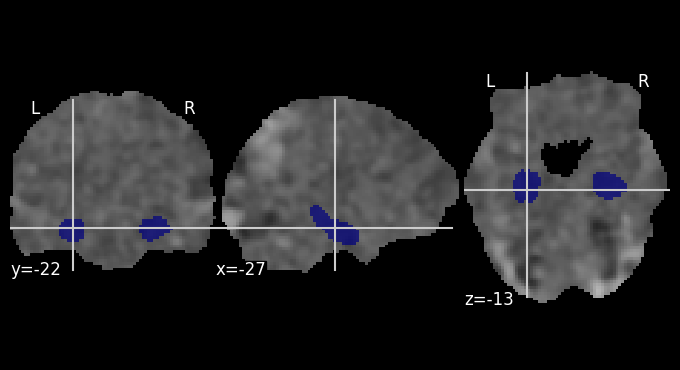

In [4]:
from nilearn.image import resample_to_img
from nilearn.plotting import plot_roi, show

#subject 001 zmap (reference image)
run1 = "/Users/graceliu/Desktop/ColumbiaThesis/zmaps/sub-001_encoding_correct_within_bt2_between_error_zmap.nii.gz"
img = nib.load(run1)

#hippocampus mask (source image)
hipp_file_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_association-test_z_FDR_0.01.nii.gz"
hipp_img = nib.load(hipp_file_path)

#resample hippocampus mask to match Z-map
resampled_hipp_mask = resample_to_img(hipp_img, img, interpolation='continuous')

#convert resampled mask to numpy array
resampled_mask_data = resampled_hipp_mask.get_fdata()

#apply threshold to only focus on hippocampus ROI
binary_mask = (resampled_mask_data > 12).astype(np.uint8)

#save resampled mask as a new NIfTI file
mask_img = nib.Nifti1Image(binary_mask, resampled_hipp_mask.affine, resampled_hipp_mask.header)

hipp_save_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_resampled.nii.gz"
nib.save(mask_img, hipp_save_path)

plot_roi(mask_img, bg_img = img)
show()

# Overall face neural patterns during category localizer for a two group split: untrustworthy and trustworthy

### median split based on ALL face ratings --> same threshold for everyone
- consistent definition of trustworthy/untrustowrthy across all participants
- easier to interpret at the populatino level (e.g. highly trusted faces activate the hippocampus more)

- doesn't account for variability in which faces each subject saw

output: average neural activation for trust/untrust faces ACROSS ALL

In [5]:
all_TD_ratings_path = '/Users/graceliu/Desktop/ColumbiaThesis/data/T_D_ratings_WSW.csv'
all_TD_ratings = pd.read_csv(all_TD_ratings_path)
all_TD_ratings.head()

,Model,Trustworthy Rating,Dominant Rating
0,BM-001,3.063830,3.230769
1,BM-002,3.617021,3.703704
2,BM-003,2.813187,4.200000
3,BM-004,3.178295,2.695312
4,BM-005,3.315217,2.846154


# Trust vs. untrust
## All faces

In [6]:
map_root = "/Users/graceliu/Desktop/ColumbiaThesis/individual_ID_maps"
hipp_mask_img = nib.load("/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_resampled.nii.gz")
hipp_data = hipp_mask_img.get_fdata().astype(bool) 

trustworthy_vals, untrustworthy_vals = [], []

# Compute overall median trust rating across all faces
overall_median = all_TD_ratings["Trustworthy Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1] #extracts face ID from file name

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id] #finds row for the face ID in all_TD_ratings
            if row.empty:
                print("Error: face rating not found for", face_id)
            trust_rating = row["Trustworthy Rating"].values[0] #pulls trust rating

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data]) #gets the average activation (beta value)

            # Classify based on overall median
            if trust_rating > overall_median:
                trustworthy_vals.append(mean_hipp) #adds beta value to trustwowrthy dict
            else:
                untrustworthy_vals.append(mean_hipp) #adds beta value to untrustwowrthy dict

# Final average results
trustworthy_vals_all = trustworthy_vals
untrustworthy_vals_all = untrustworthy_vals
print(f"Trustworthy mean: {np.mean(trustworthy_vals_all):.4f} (n={len(trustworthy_vals_all)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals_all):.4f} (n={len(untrustworthy_vals_all)})")

Trustworthy mean: 0.0322 (n=1889)
Untrustworthy mean: 0.0295 (n=1831)


In [7]:
subject_ids = []
trustworthy_vals_subj = []
untrustworthy_vals_subj = []

# Loop through subjects
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue  # skip subject 11

    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')
        continue

    face_ids_seen = []
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]
            face_ids_seen.append(face_id)

    # Check for duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: duplicates for {sub_id}"

    # Prepare per-condition storage
    sub_trust_vals = []
    sub_untrust_vals = []

    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
                continue
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load beta map
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Overall-level split
            if trust_rating > overall_median:
                sub_trust_vals.append(mean_hipp)
            else:
                sub_untrust_vals.append(mean_hipp)

    # Store subject-level means
    subject_ids.append(sub_id)
    trustworthy_vals_subj.append(np.mean(sub_trust_vals))
    untrustworthy_vals_subj.append(np.mean(sub_untrust_vals))

# Compute neural difference
neural_diff = np.array(trustworthy_vals_subj) - np.array(untrustworthy_vals_subj)

# Save to DataFrame
neural_diff_df = pd.DataFrame({
    "subj_id": subject_ids,
    "mean_trustworthy": trustworthy_vals_subj,
    "mean_untrustworthy": untrustworthy_vals_subj,
    "neural_diff": neural_diff
})

# neural_diff_df.head()

# Export to CSV
neural_diff_df.to_csv("hipp_trust_diff_overall_ALL.csv", index=False)
print("Saved: hipp_trust_diff_overall_ALL.csv")

Saved: hipp_trust_diff_overall_ALL.csv


In [8]:
from scipy.stats import ttest_ind

t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals_all, untrustworthy_vals_all, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

trust_all_p_value = p_val_hipp

t = 0.7789
p = 0.4361


## BM only

In [9]:
trustworthy_vals, untrustworthy_vals = [], []

# Compute overall median trust rating across all faces
overall_median = all_TD_ratings["Trustworthy Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on overall median
            if trust_rating > overall_median:
                trustworthy_vals.append(mean_hipp)
            else:
                untrustworthy_vals.append(mean_hipp)

trustworthy_vals_BM = trustworthy_vals
untrustworthy_vals_BM = untrustworthy_vals

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals_BM):.4f} (n={len(trustworthy_vals_BM)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals_BM):.4f} (n={len(untrustworthy_vals_BM)})")

Trustworthy mean: 0.0334 (n=1239)
Untrustworthy mean: 0.0270 (n=621)


In [10]:
subject_ids = []
trustworthy_vals_subj = []
untrustworthy_vals_subj = []

# Loop through subjects
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue  # skip subject 11

    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')
        continue

    face_ids_seen = []
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'BM-' in f:
            face_id = f.split("_")[1]
            face_ids_seen.append(face_id)

    # Check for duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: duplicates for {sub_id}"

    # Prepare per-condition storage
    sub_trust_vals = []
    sub_untrust_vals = []

    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'BM-' in f:
            face_id = f.split("_")[1]
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
                continue
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load beta map
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Overall-level split
            if trust_rating > overall_median:
                sub_trust_vals.append(mean_hipp)
            else:
                sub_untrust_vals.append(mean_hipp)

    # Store subject-level means
    subject_ids.append(sub_id)
    trustworthy_vals_subj.append(np.mean(sub_trust_vals))
    untrustworthy_vals_subj.append(np.mean(sub_untrust_vals))

# Compute neural difference
neural_diff = np.array(trustworthy_vals_subj) - np.array(untrustworthy_vals_subj)

# Save to DataFrame
neural_diff_df = pd.DataFrame({
    "subj_id": subject_ids,
    "mean_trustworthy": trustworthy_vals_subj,
    "mean_untrustworthy": untrustworthy_vals_subj,
    "neural_diff": neural_diff
})

# Export to CSV
neural_diff_df.to_csv("hipp_trust_diff_overall_BM.csv", index=False)
print("Saved: hipp_trust_diff_overall_BM.csv")

Saved: hipp_trust_diff_overall_BM.csv


In [11]:
t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals_BM, untrustworthy_vals_BM, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

trust_BM_p_value = p_val_hipp

t = 1.2500
p = 0.2115


## WM only

In [12]:
trustworthy_vals, untrustworthy_vals = [], []

# Compute overall median trust rating across all faces
overall_median = all_TD_ratings["Trustworthy Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on overall median
            if trust_rating > overall_median:
                trustworthy_vals.append(mean_hipp)
            else:
                untrustworthy_vals.append(mean_hipp)

trustworthy_vals_WM = trustworthy_vals
untrustworthy_vals_WM = untrustworthy_vals

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals_WM):.4f} (n={len(trustworthy_vals_WM)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals_WM):.4f} (n={len(untrustworthy_vals_WM)})")

Trustworthy mean: 0.0298 (n=650)
Untrustworthy mean: 0.0308 (n=1210)


In [13]:
subject_ids = []
trustworthy_vals_subj = []
untrustworthy_vals_subj = []

# Loop through subjects
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue  # skip subject 11

    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')
        continue

    face_ids_seen = []
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'WM-' in f:
            face_id = f.split("_")[1]
            face_ids_seen.append(face_id)

    # Check for duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: duplicates for {sub_id}"

    # Prepare per-condition storage
    sub_trust_vals = []
    sub_untrust_vals = []

    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'WM-' in f:
            face_id = f.split("_")[1]
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
                continue
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load beta map
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Overall-level split
            if trust_rating > overall_median:
                sub_trust_vals.append(mean_hipp)
            else:
                sub_untrust_vals.append(mean_hipp)

    # Store subject-level means
    subject_ids.append(sub_id)
    trustworthy_vals_subj.append(np.mean(sub_trust_vals))
    untrustworthy_vals_subj.append(np.mean(sub_untrust_vals))

# Compute neural difference
neural_diff = np.array(trustworthy_vals_subj) - np.array(untrustworthy_vals_subj)

# Save to DataFrame
neural_diff_df = pd.DataFrame({
    "subj_id": subject_ids,
    "mean_trustworthy": trustworthy_vals_subj,
    "mean_untrustworthy": untrustworthy_vals_subj,
    "neural_diff": neural_diff
})

# Export to CSV
neural_diff_df.to_csv("hipp_trust_diff_overall_WM.csv", index=False)
print("Saved: hipp_trust_diff_overall_WM.csv")

Saved: hipp_trust_diff_overall_WM.csv


In [14]:
t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals_WM, untrustworthy_vals_WM, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

trust_WM_p_value = p_val_hipp

t = -0.1849
p = 0.8533


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

mean_all_trustworthy = np.mean(trustworthy_vals_all)
mean_all_untrustworthy = np.mean(untrustworthy_vals_all)
mean_black_trustworthy = np.mean(trustworthy_vals_BM)
mean_black_untrustworthy = np.mean(untrustworthy_vals_BM)
mean_white_trustworthy = np.mean(trustworthy_vals_WM)
mean_white_untrustworthy = np.mean(untrustworthy_vals_WM)

se_all_trustworthy = np.std(trustworthy_vals_all) / np.sqrt(len(trustworthy_vals_all))
se_all_untrustworthy = np.std(untrustworthy_vals_all) / np.sqrt(len(untrustworthy_vals_all))
se_black_trustworthy = np.std(trustworthy_vals_BM) / np.sqrt(len(trustworthy_vals_BM))
se_black_untrustworthy = np.std(untrustworthy_vals_BM) / np.sqrt(len(untrustworthy_vals_BM))
se_white_trustworthy = np.std(trustworthy_vals_WM) / np.sqrt(len(trustworthy_vals_WM))
se_white_untrustworthy = np.std(untrustworthy_vals_WM) / np.sqrt(len(untrustworthy_vals_WM))

# # Replace these with your actual computed means
# data = {
#     'Group': ['All Faces', 'All Faces', 'Black Males', 'Black Males', 'White Males', 'White Males'],
#     'Trust Level': ['Trustworthy', 'Untrustworthy'] * 3,
#     'Mean Beta': [
#         mean_all_trustworthy, mean_all_untrustworthy,
#         mean_black_trustworthy, mean_black_untrustworthy,
#         mean_white_trustworthy, mean_white_untrustworthy
#     ],
#     'SE': [
#         se_all_trustworthy, se_all_untrustworthy,
#         se_black_trustworthy, se_black_untrustworthy,
#         se_white_trustworthy, se_white_untrustworthy
#     ]
# }

# df = pd.DataFrame(data)


# # Plotting
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(data=df, x='Group', y='Mean Beta', hue='Trust Level', palette='Set2')
# plt.title('Hippocampal Activity by Trust Level and Race', fontsize = 16)
# plt.ylabel('Mean Beta Value', fontweight = 'bold')
# plt.xlabel('Face Group', fontweight = 'bold')
# plt.ylim(0.020, 0.040)
# ax.legend(title='Trust Level', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.tight_layout()
# plt.show()

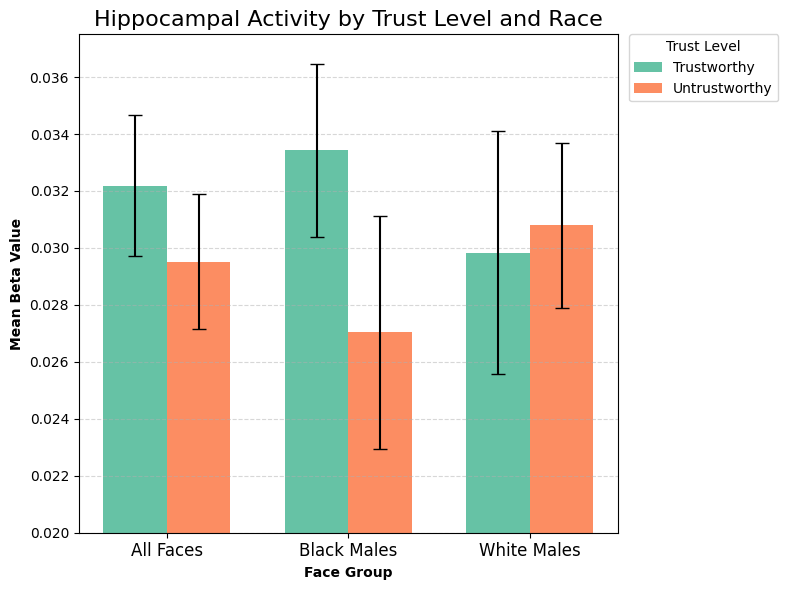

In [ ]:
# Means
mean_all_trustworthy = np.mean(trustworthy_vals_all)
mean_all_untrustworthy = np.mean(untrustworthy_vals_all)
mean_black_trustworthy = np.mean(trustworthy_vals_BM)
mean_black_untrustworthy = np.mean(untrustworthy_vals_BM)
mean_white_trustworthy = np.mean(trustworthy_vals_WM)
mean_white_untrustworthy = np.mean(untrustworthy_vals_WM)

# Standard Errors
se_all_trustworthy = np.std(trustworthy_vals_all) / np.sqrt(len(trustworthy_vals_all))
se_all_untrustworthy = np.std(untrustworthy_vals_all) / np.sqrt(len(untrustworthy_vals_all))
se_black_trustworthy = np.std(trustworthy_vals_BM) / np.sqrt(len(trustworthy_vals_BM))
se_black_untrustworthy = np.std(untrustworthy_vals_BM) / np.sqrt(len(untrustworthy_vals_BM))
se_white_trustworthy = np.std(trustworthy_vals_WM) / np.sqrt(len(trustworthy_vals_WM))
se_white_untrustworthy = np.std(untrustworthy_vals_WM) / np.sqrt(len(untrustworthy_vals_WM))

# Grouped data
groups = ['All Faces', 'Black Males', 'White Males']
x = np.arange(len(groups))
bar_width = 0.35

means_trustworthy = [mean_all_trustworthy, mean_black_trustworthy, mean_white_trustworthy]
means_untrustworthy = [mean_all_untrustworthy, mean_black_untrustworthy, mean_white_untrustworthy]
errors_trustworthy = [se_all_trustworthy, se_black_trustworthy, se_white_trustworthy]
errors_untrustworthy = [se_all_untrustworthy, se_black_untrustworthy, se_white_untrustworthy]

# Create the plot
plt.figure(figsize=(8, 6))
trust_x = x - bar_width / 2
untrust_x = x + bar_width / 2

# Plot bars
plt.bar(trust_x, means_trustworthy, yerr=errors_trustworthy, width=bar_width, label='Trustworthy',
        capsize=5, color='#66c2a5')
plt.bar(untrust_x, means_untrustworthy, yerr=errors_untrustworthy, width=bar_width, label='Untrustworthy',
        capsize=5, color='#fc8d62')

# Labels and formatting
plt.title('Hippocampal Activity by Trust Level and Race', fontsize=16)
plt.xlabel('Face Group', fontweight='bold')
plt.ylabel('Mean Beta Value', fontweight='bold')
plt.xticks(x, groups, fontsize=12)
plt.ylim(0.02, 0.0375)
plt.legend(title='Trust Level', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Dom vs. undom 
## All faces

In [ ]:
dominant_vals, undominant_vals = [], []

# Compute overall median dom rating across all faces
overall_median = all_TD_ratings["Dominant Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1] #extracts face ID from file name

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id] #finds row for the face ID in all_TD_ratings
            if row.empty:
                print("Error: face rating not found for", face_id)
            dom_rating = row["Dominant Rating"].values[0] #pulls dom rating

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data]) #gets the average activation (beta value)

            # Classify based on overall median
            if dom_rating > overall_median:
                dominant_vals.append(mean_hipp) #adds beta value to trustwowrthy dict
            else:
                undominant_vals.append(mean_hipp) #adds beta value to untrustwowrthy dict

dominant_vals_all = dominant_vals
nondominant_vals_all = undominant_vals

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(undominant_vals):.4f} (n={len(undominant_vals)})")

Dominant mean: 0.0312 (n=1815)
Nondominant mean: 0.0306 (n=1905)


In [ ]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals, undominant_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

dom_all_p_value = p_val_hipp

t = 0.1851
p = 0.8531


## BM only

In [ ]:
dominant_vals, undominant_vals = [], []

# Compute overall median dom rating across all faces
overall_median = all_TD_ratings["Dominant Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'BM-' in f:
            face_id = f.split("_")[1] #extracts face ID from file name

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id] #finds row for the face ID in all_TD_ratings
            if row.empty:
                print("Error: face rating not found for", face_id)
            dom_rating = row["Dominant Rating"].values[0] #pulls dom rating

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data]) #gets the average activation (beta value)

            # Classify based on overall median
            if dom_rating > overall_median:
                dominant_vals.append(mean_hipp) #adds beta value to trustwowrthy dict
            else:
                undominant_vals.append(mean_hipp) #adds beta value to untrustwowrthy dict

dominant_vals_BM = dominant_vals
nondominant_vals_BM = undominant_vals

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(undominant_vals):.4f} (n={len(undominant_vals)})")

Dominant mean: 0.0306 (n=1134)
Nondominant mean: 0.0323 (n=726)


In [ ]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals_BM, nondominant_vals_BM, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

dom_BM_p_value = p_val_hipp

t = -0.3390
p = 0.7346


## WM only

In [ ]:
dominant_vals, undominant_vals = [], []

# Compute overall median dom rating across all faces
overall_median = all_TD_ratings["Dominant Rating"].median()

for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    # Check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    #loops through all.nii.gz files in the subejcts folder
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'WM-' in f:
            face_id = f.split("_")[1] #extracts face ID from file name

            # Get trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id] #finds row for the face ID in all_TD_ratings
            if row.empty:
                print("Error: face rating not found for", face_id)
            dom_rating = row["Dominant Rating"].values[0] #pulls dom rating

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data]) #gets the average activation (beta value)

            # Classify based on overall median
            if dom_rating > overall_median:
                dominant_vals.append(mean_hipp) #adds beta value to trustwowrthy dict
            else:
                undominant_vals.append(mean_hipp) #adds beta value to untrustwowrthy dict
                

dominant_vals_WM = dominant_vals
nondominant_vals_WM = undominant_vals
# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(undominant_vals):.4f} (n={len(undominant_vals)})")

Dominant mean: 0.0322 (n=681)
Nondominant mean: 0.0295 (n=1179)


In [ ]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals_WM, nondominant_vals_WM, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

dom_WM_p_value = p_val_hipp

t = 0.5420
p = 0.5879


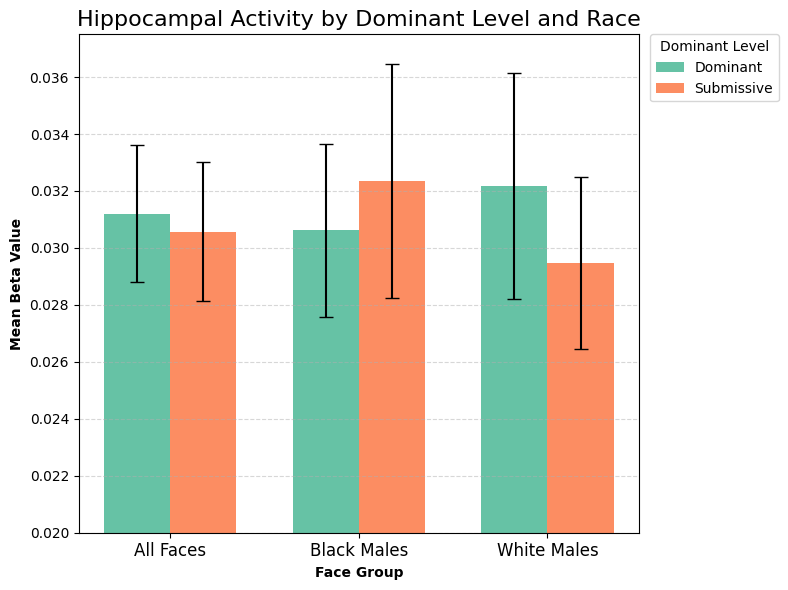

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mean_all_dominant = np.mean(dominant_vals_all)
mean_all_nondominant = np.mean(nondominant_vals_all)

mean_black_dominant = np.mean(dominant_vals_BM)
mean_black_nondominant = np.mean(nondominant_vals_BM)

mean_white_dominant = np.mean(dominant_vals_WM)
mean_white_nondominant = np.mean(nondominant_vals_WM)

se_all_dominant = np.std(dominant_vals_all) / np.sqrt(len(dominant_vals_all))
se_all_nondominant = np.std(nondominant_vals_all) / np.sqrt(len(nondominant_vals_all))
se_black_dominant = np.std(dominant_vals_BM) / np.sqrt(len(dominant_vals_BM))
se_black_nondominant = np.std(nondominant_vals_BM) / np.sqrt(len(nondominant_vals_BM))
se_white_dominant = np.std(dominant_vals_WM) / np.sqrt(len(dominant_vals_WM))
se_white_nondominant = np.std(nondominant_vals_WM) / np.sqrt(len(nondominant_vals_WM))


# Grouped data
groups = ['All Faces', 'Black Males', 'White Males']
x = np.arange(len(groups))
bar_width = 0.35

means_dominant = [mean_all_dominant, mean_black_dominant, mean_white_dominant]
means_nondominant = [mean_all_nondominant, mean_black_nondominant, mean_white_nondominant]
errors_dominant = [se_all_dominant, se_black_dominant, se_white_dominant]
errors_nondominant = [se_all_nondominant, se_black_nondominant, se_white_nondominant]

# Create the plot
plt.figure(figsize=(8, 6))
dom_x = x - bar_width / 2
sub_x = x + bar_width / 2

# Plot bars
plt.bar(dom_x, means_dominant, yerr=errors_dominant, width=bar_width, label='Dominant',
        capsize=5, color='#66c2a5')
plt.bar(sub_x, means_nondominant, yerr=errors_nondominant, width=bar_width, label='Submissive',
        capsize=5, color='#fc8d62')

# Labels and formatting
plt.title('Hippocampal Activity by Dominant Level and Race', fontsize=16)
plt.xlabel('Face Group', fontweight='bold')
plt.ylabel('Mean Beta Value', fontweight='bold')
plt.xticks(x, groups, fontsize=12)
plt.ylim(0.02, 0.0375)
plt.legend(title='Dominant Level', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# # Replace these with your actual computed means
# data = {
#     'Group': ['All Faces', 'All Faces', 'Black Males', 'Black Males', 'White Males', 'White Males'],
#     'Dom Level': ['Dominant', 'Submissive'] * 3,
#     'Mean Beta': [
#         mean_all_dominant, mean_all_nondominant,
#         mean_black_dominant, mean_black_nondominant,
#         mean_white_dominant, mean_white_nondominant
#     ],
#     'SE': [
#         se_all_dominant, se_all_nondominant,
#         se_black_dominant, se_black_nondominant,
#         se_white_dominant, se_white_nondominant
#     ]
# }

# df = pd.DataFrame(data)

# for i, row in df.iterrows():
#     ax.errorbar(x=i//2 + (0.15 if row['Dom Level'] == 'Dominant' else -0.15),
#                 y=row['Mean Beta'],
#                 yerr=row['SE'],
#                 fmt='none',
#                 c='black',
#                 capsize=5)
    

# # Plotting
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(data=df, x='Group', y='Mean Beta', hue='Dom Level', palette='Set2')
# plt.title('Hippocampal Activity by Dominant Level and Race', fontsize = 16)
# plt.ylabel('Mean Beta Value', fontweight = 'bold')
# plt.xlabel('Face Group', fontweight = 'bold')
# plt.ylim(0.020, 0.040)
# ax.legend(title='Dominant Level', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.tight_layout()
# plt.show()